In [1]:
import sys
sys.path.append('.')

%load_ext autoreload
%autoreload 2

In [2]:
import pyro

pyro.set_rng_seed(100)

In [3]:
from IPython.display import Code, display
import numpy as np

from src.mcmc import dataset
from src.mcmc import infer
from src.mcmc import model
from src.mcmc import vis


Bad key "text.kerning_factor" on line 4 in
C:\Users\Wilk-PC\Anaconda3\envs\lab\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


# Dataset generation

In [4]:
display(Code('src/mcmc/dataset.py'))

"""Function for dataset generation."""
import numpy as np
from sklearn import model_selection as sk_ms
import torch


def generate_dataset(num_total, train_size):
    """Generates dataset with `num_total` samples and given train size."""
    # Data generator parameters
    means = {0: 0.99, 1: 0.75}
    stds = {0: 10, 1: 5}

    # Dataset
    ds = {'train': {}, 'test': {}}

    speed_limits = np.random.uniform(low=30, high=240, size=(num_total,))

    for is_cold in [0, 1]:
        measurements = [
            torch.distributions.Normal(
                means[is_cold] * sl,
                stds[is_cold]
            ).sample().item()
            for sl in speed_limits
        ]

        xtr, xte, ytr, yte = sk_ms.train_test_split(
            speed_limits.tolist(), measurements,
            train_size=train_size,
        )

        ds['train'][is_cold] = {
            'speed_limit': torch.tensor(xtr),
            'measurement': torch.tensor(ytr),
        }
        ds['test'][is_cold] = {
            'speed_limit': torch.tensor(xte),
            'measurement': torch.tensor(yte),
        }

    return ds

# Model

In [5]:
display(Code('src/mcmc/model.py'))

"""Implementation of speedometer model."""
import torch
import pyro
import pyro.distributions as dist


def speedometer_model(speed_limit, is_cold, measurement=None):
    """Model for measuring vehicle speed given `speed_limit` and `is_cold`."""
    #     c_means = {0: torch.tensor(0.99), 1: torch.tensor(0.75)}
    #     measurement_stds = {0: torch.tensor(10.), 1: torch.tensor(5.)}
    c_means = {0: torch.tensor(0.2), 1: torch.tensor(0.1)}
    measurement_stds = {0: torch.tensor(1.), 1: torch.tensor(2.)}

    c = pyro.sample('c', dist.Normal(c_means[is_cold], 0.01))
    std = pyro.sample('std', dist.Normal(measurement_stds[is_cold], 2.))

    with pyro.plate("data", len(speed_limit)):
        return pyro.sample(
            "measurement",
            dist.Normal(c * speed_limit, std),
            obs=measurement,
        )

# MCMC
## Infer functions

In [6]:
display(Code('src/mcmc/infer.py'))

"""Utility functions for MCMC."""
import pyro


def run_mcmc(kernel, model_args, num_samples, warmup_steps):
    """Executes MCMC using given `kernel` and `data`."""
    pyro.clear_param_store()

    mcmc_posterior = pyro.infer.MCMC(
        kernel=kernel,
        num_samples=num_samples,
        warmup_steps=warmup_steps,
    )

    mcmc_posterior.run(*model_args)
    return mcmc_posterior


def sample_mcmc(mcmc_posterior):
    """Extracts samples from MCMC posterior."""
    return {
        k: v.detach().cpu()
        for k, v in mcmc_posterior.get_samples().items()
    }

## Generate data

In [12]:
ds = dataset.generate_dataset(2_000, train_size=0.6)

## Estimate model parameters 

In [13]:
posteriors = {}

### HMC (Hamiltoniam Monte Carlo)
[HMC in pyro](http://docs.pyro.ai/en/stable/mcmc.html#hmc)

In [14]:
from pyro.infer import HMC

In [15]:
hmc_kernel = lambda: HMC(
    model=model.speedometer_model,
    num_steps=20,
    step_size=1e-4,
    adapt_step_size=False,
)

posteriors['HMC'] = {
    ic: infer.run_mcmc(
        kernel=hmc_kernel(),
        model_args=(ds['train'][ic]['speed_limit'], ic, ds['train'][ic]['measurement']),
        num_samples=1_000,
        warmup_steps=200,
    )
    for ic in (0, 1)
}

posteriors['HMC'][0].summary()
posteriors['HMC'][1].summary()

Sample: 100%|███████████████████████████████████████| 1200/1200 [00:31, 38.65it/s, step size=1.00e-04, acc. prob=1.000]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         c      0.95      0.00      0.95      0.95      0.95      6.26      1.33
       std     11.15      0.00     11.15     11.15     11.15      3.36      2.02

Number of divergences: 0

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         c      0.74      0.01      0.75      0.74      0.75     22.83      1.05
       std      4.35      0.00      4.35      4.35      4.36      7.28      1.08

Number of divergences: 0


### NUTS (No-U-Turn Sampler)
[NUTS in pyro](http://docs.pyro.ai/en/stable/mcmc.html#nuts)

In [16]:
from pyro.infer import NUTS

In [17]:
nuts_kernel = lambda: NUTS(model.speedometer_model)

posteriors['NUTS'] = {
    ic: infer.run_mcmc(
        kernel=nuts_kernel(),
        model_args=(ds['train'][ic]['speed_limit'], ic, ds['train'][ic]['measurement']),
        num_samples=1_000,
        warmup_steps=500,
    )
    for ic in (0, 1)
}

posteriors['NUTS'][0].summary()
posteriors['NUTS'][1].summary()

Sample: 100%|███████████████████████████████████████| 1500/1500 [00:20, 71.82it/s, step size=1.85e-01, acc. prob=0.944]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         c      0.95      0.00      0.95      0.95      0.96    593.85      1.00
       std     11.04      0.28     11.01     10.59     11.48    353.10      1.01

Number of divergences: 0

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         c      0.74      0.00      0.74      0.74      0.75    722.25      1.00
       std      5.16      0.11      5.16      4.98      5.34    199.37      1.01

Number of divergences: 0


## Make predictors

In [20]:
from pyro.infer import Predictive

In [21]:
mcmc_predictive = {
    name: {
        ic: Predictive(
            lambda sl: model.speedometer_model(sl, ic),
            posterior_samples=infer.sample_mcmc(posteriors[name][ic]),
            return_sites=('measurement',)
        )
        for ic in (0, 1)
    }
    for name in ('HMC', 'NUTS')
}

mcmc_predictive

{'HMC': {0: Predictive(), 1: Predictive()},
 'NUTS': {0: Predictive(), 1: Predictive()}}

## Plot predictions and real samples

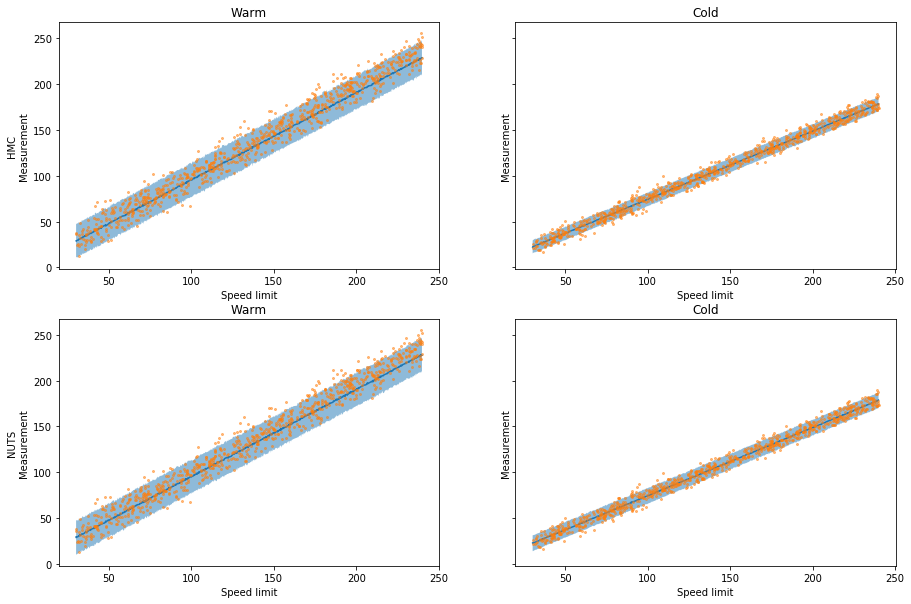

In [22]:
vis.plot_predictions(ds['test'], mcmc_predictive)